# Sauces Data QC for WRF Comparison
__Author__: Pat McCornack

__Date__: 11/15/24

__Purpose__: Clean and check the Sauces data to be used in WRF model validation. 

__Notes__:
- The fog drip data should really only be used for summer months. It's likely that there's significant rain bycatch in the winter.
- We do have data for summer 2011, but it doesn't have wind variables - it's currently not included in this script. 


__TO DO__:
- Follow up on notes in individual sections

In [256]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Prepare Data 

In [257]:
#### Read in Data ####
df_original = pd.read_csv('/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/Still Lab Data/relevant/SAUC/SAUCdata_joined.csv')

# Create single datetime column
times = []
for index, row in df_original.iterrows():
    times.append(f"{str(row['Year']).split('.')[0]}-{str(row['Month']).split('.')[0]}-{str(row['Day']).split('.')[0]} {str(row['Hour']).split('.')[0]}:{str(row['Minute']).split('.')[0]}:00")

df_original['time'] = pd.to_datetime(times)
df_original = df_original.sort_values(by='time', ascending=True)

# Subset to relevant variables
var_dict = {'time (PST)' : df_original['time'],
            'air temperature (C)' : df_original['Temp'],
            'relative humidity (%)' : df_original['RH'],
            'wind speed (m/s)' : df_original['WindSpd'],
            'wind direction (deg)' : df_original['WindDir'],
            'wind gust (m/s)' : df_original['WS_MS_MAX'],
            'rain (mm)' : df_original['Rain'],
            'fog drip' : df_original['Fog']}

df = pd.DataFrame(var_dict)
df.head()


,time (PST),air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm),fog drip
0,2003-12-19 16:00:00,15.53,27.54,0.63,92.21,0.95,0.0,0.0
1,2003-12-19 17:00:00,15.22,27.05,1.40,99.26,3.96,0.0,0.0
2,2003-12-19 18:00:00,14.68,32.86,2.07,140.33,3.75,0.0,0.0
3,2003-12-19 19:00:00,12.89,60.68,2.22,122.58,3.51,0.0,0.0
4,2003-12-19 20:00:00,13.53,49.79,2.62,119.99,4.60,0.0,0.0


In [258]:
#### Add attributes to dataframe #### 
#! TO DO : Get geographic information
df.attrs['Description'] = 'Sauces Canyon Met Station (From Chris Still)'
df.attrs['Code'] = 'SAUC'
df.attrs['Latitude'] = 34.001033 
df.attrs['Longitude'] = -119.817817
#df.attrs['Elevation m'] = 

# Data QC Checks

## Summary Stats

__Things to check__:

Air temperature minimum outlier:
- This is isn't unreasonable, but still should be checked. 

RH minimum outlier
- Seems unlikely to have close to 0 RH, but not entirely impossible on a hot day. 

Fog drip maximum outlier
- Exceedingly high, probably a rain event in the winter.
- Reminder that fog drip data should only be consider valid in the summer for this dataset due to significant winter rain bycatch. 

In [259]:
df.describe()

,time (PST),air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm),fog drip
count,199751,198570.000000,198570.000000,97810.000000,198566.000000,198565.000000,198566.000000,198566.000000
mean,2007-02-14 19:14:48.853122048,14.001350,70.533603,2.005275,244.382334,2.560273,0.006952,0.969242
min,2003-12-19 16:00:00,3.100000,0.539000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005-08-12 10:52:30,10.630000,56.320000,0.790000,152.400000,1.300000,0.000000,0.000000
50%,2007-01-14 15:15:00,12.790000,80.900000,1.930000,319.430000,2.500000,0.000000,0.000000
75%,2008-09-16 10:52:30,16.440000,94.700000,2.960000,325.500000,3.700000,0.000000,0.000000
max,2010-02-18 15:15:00,40.670000,104.700000,16.120000,359.900000,20.450000,11.000000,386.550000
std,NaN,4.815355,29.321088,1.509726,119.690723,1.791054,0.095072,7.674538


In [260]:
df.set_index('time (PST)', inplace=True)

## Air Temperature Outlier
- Note the data gap around 2008
- Check the very high (~40) value.
- The minimum value near 0 seems reasonable from visual inspection - no big jumps. 

__Findings__:
For both the min/max outliers, they seem to be real. When zooming in on the data, there's no suspicious spikes and the RH data tracks well with the air temperature as expected. 

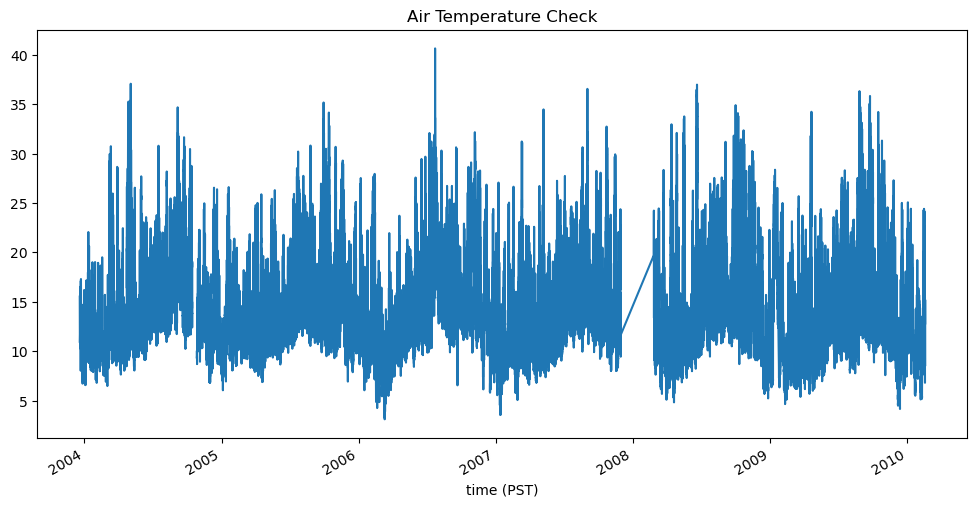

In [261]:
plt.figure(figsize=(12,6))
df['air temperature (C)'].plot()
plt.title('Air Temperature Check')
plt.show()

In [262]:
#### Find min/max air temperature observations
airtemps = df['air temperature (C)']
max_at = airtemps.loc[airtemps == airtemps.max()]
min_at = airtemps.loc[airtemps == airtemps.min()]

print(max_at)
print(min_at)

time (PST)
2006-07-23 15:15:00    40.67
Name: air temperature (C), dtype: float64
time (PST)
2006-03-11 05:45:00    3.1
Name: air temperature (C), dtype: float64


air temperature (C)       40.67
relative humidity (%)     18.70
wind speed (m/s)           1.24
wind direction (deg)     327.30
wind gust (m/s)            2.35
rain (mm)                  0.00
fog drip                   0.00
Name: 2006-07-23 15:15:00, dtype: float64


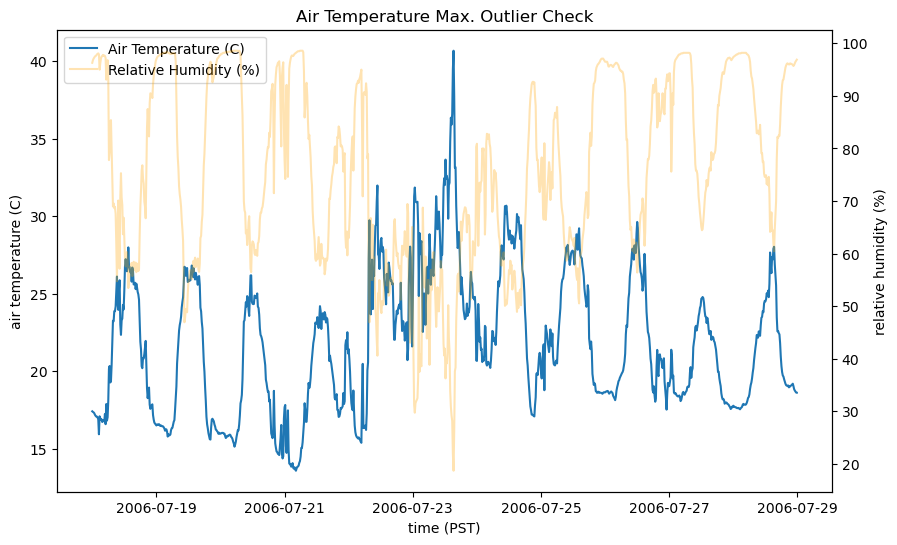

In [263]:
#### Check the max air temp values ####
print(df.loc['2006-07-23 15:15:00'])
at_max_subset = df['2006-07-18':'2006-07-28']

# Plot Temperature/RH
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=at_max_subset['air temperature (C)'],
             label='Air Temperature (C)')
ax2 = ax.twinx()
sns.lineplot(data=at_max_subset['relative humidity (%)'],
             label='Relative Humidity (%)',
             color='orange',
             alpha=0.3,
             ax=ax2)
ax2.legend_.remove()

plt.title('Air Temperature Max. Outlier Check')

# Combine legends
handles1, labels1 = ax.get_legend_handles_labels()  # Handles and labels from ax
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles and labels from ax2
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combine and set location

plt.show()


air temperature (C)        3.10
relative humidity (%)     96.30
wind speed (m/s)           0.62
wind direction (deg)     332.80
wind gust (m/s)            1.16
rain (mm)                  0.00
fog drip                   0.00
Name: 2006-03-11 05:45:00, dtype: float64


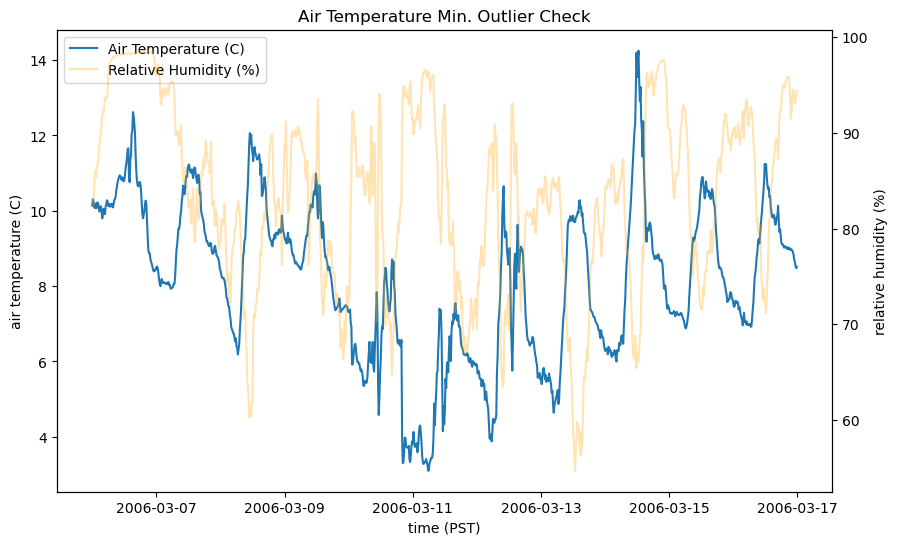

In [264]:
#### Check the minimum air temperature values ####
print(df.loc['2006-03-11 05:45:00'])
at_min_subset = df['2006-03-06':'2006-03-16']

# Plot Temperature/RH
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=at_min_subset['air temperature (C)'],
             label='Air Temperature (C)')
ax2 = ax.twinx()
sns.lineplot(data=at_min_subset['relative humidity (%)'],
             label='Relative Humidity (%)',
             color='orange',
             alpha=0.3,
             ax=ax2)
ax2.legend_.remove()

plt.title('Air Temperature Min. Outlier Check')

# Combine legends
handles1, labels1 = ax.get_legend_handles_labels()  # Handles and labels from ax
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles and labels from ax2
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combine and set location

plt.show()

## RH Outlier Check
- The late 2009 data looks suspect, likely sensor failure. 

__Findings__: Starting in October 2009, the RH data never gets above ~13%. There are a few errant points in the preceding months tha tmay be suspect as well. The suspect block of data will be remove. I should likely follow up on this dataset with methods to try and determine the calibration quality of the sensor. 

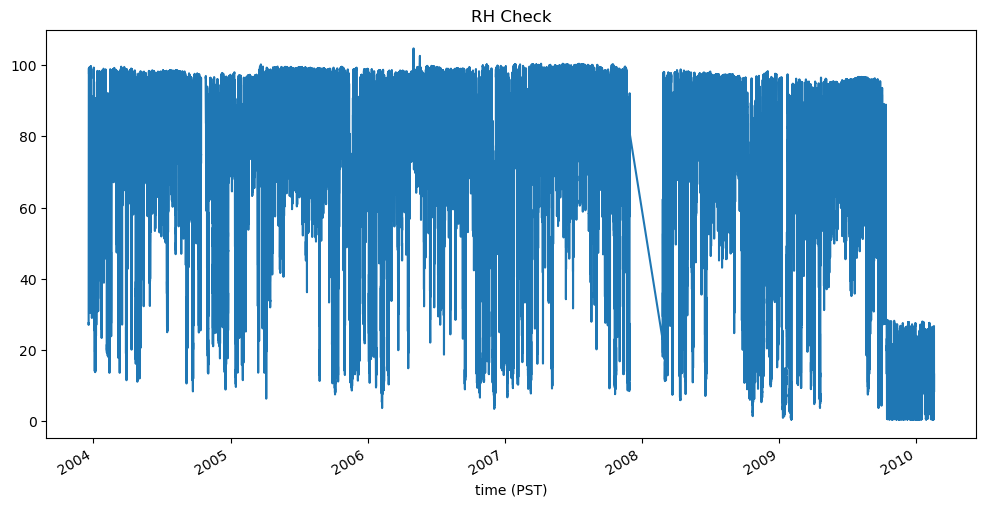

In [265]:
plt.figure(figsize=(12,6))
df['relative humidity (%)'].plot()
plt.title('RH Check')
plt.show()

In [266]:
#### Check the suspicious minimum value ####
min_rh = df.loc[df['relative humidity (%)'] == df['relative humidity (%)'].min()]
min_rh


,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain (mm),fog drip
time (PST),,,,,,,
2009-02-02 11:45:00,23.82,0.539,NaN,145.4,4.850,0.0,0.0
2009-02-03 11:30:00,24.38,0.539,NaN,152.1,4.275,0.0,0.0
2009-02-03 12:00:00,24.97,0.539,NaN,162.9,3.637,0.0,0.0
2009-02-03 12:15:00,25.01,0.539,NaN,161.2,4.237,0.0,0.0
2009-02-03 12:30:00,24.75,0.539,NaN,148.8,4.475,0.0,0.0
...,...,...,...,...,...,...,...
2010-02-14 13:00:00,18.63,0.539,NaN,0.0,0.000,0.0,0.0
2010-02-14 13:15:00,19.21,0.539,NaN,0.0,0.000,0.0,0.0
2010-02-14 13:30:00,19.34,0.539,NaN,0.0,0.000,0.0,0.0


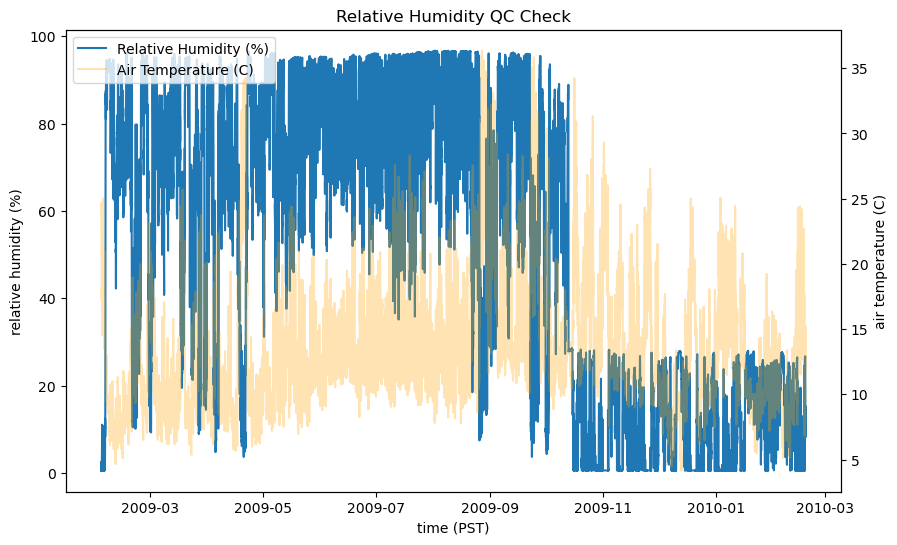

In [267]:
rh_subset = df['2009-02-02 11:45:00	':'2010-02-18 15:15:00']

# Plot Temperature/RH
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rh_subset['relative humidity (%)'],
             label='Relative Humidity (%)')
ax2 = ax.twinx()
sns.lineplot(data=rh_subset['air temperature (C)'],
             label='Air Temperature (C)',
             color='orange',
             alpha=0.3,
             ax=ax2)
ax2.legend_.remove()

plt.title('Relative Humidity QC Check')

# Combine legends
handles1, labels1 = ax.get_legend_handles_labels()  # Handles and labels from ax
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles and labels from ax2
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combine and set location

plt.show()


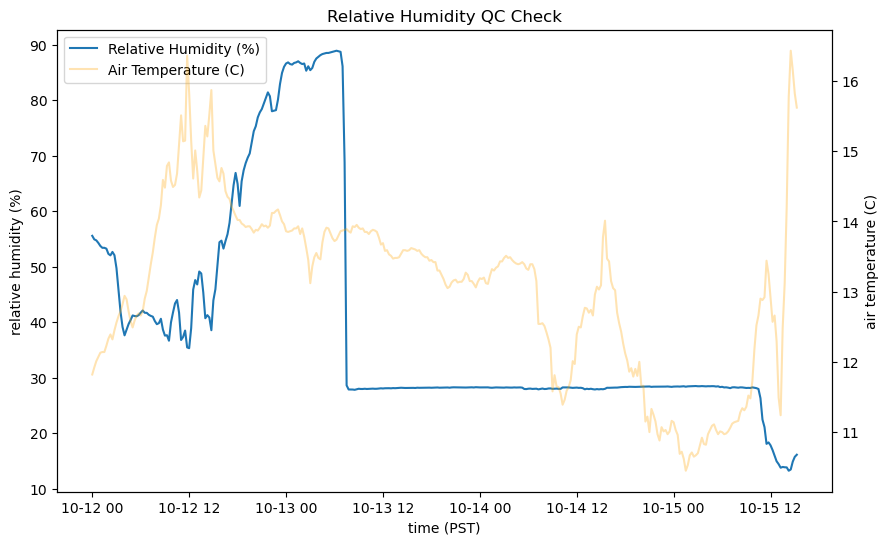

In [268]:
#### Determine where the sensor fails (10/13) 

rh_subset = df['2009-10-12 00:00:00	':'2009-10-15 15:15:00']

# Plot Temperature/RH
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rh_subset['relative humidity (%)'],
             label='Relative Humidity (%)')
ax2 = ax.twinx()
sns.lineplot(data=rh_subset['air temperature (C)'],
             label='Air Temperature (C)',
             color='orange',
             alpha=0.3,
             ax=ax2)
ax2.legend_.remove()

plt.title('Relative Humidity QC Check')

# Combine legends
handles1, labels1 = ax.get_legend_handles_labels()  # Handles and labels from ax
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles and labels from ax2
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combine and set location

plt.show()


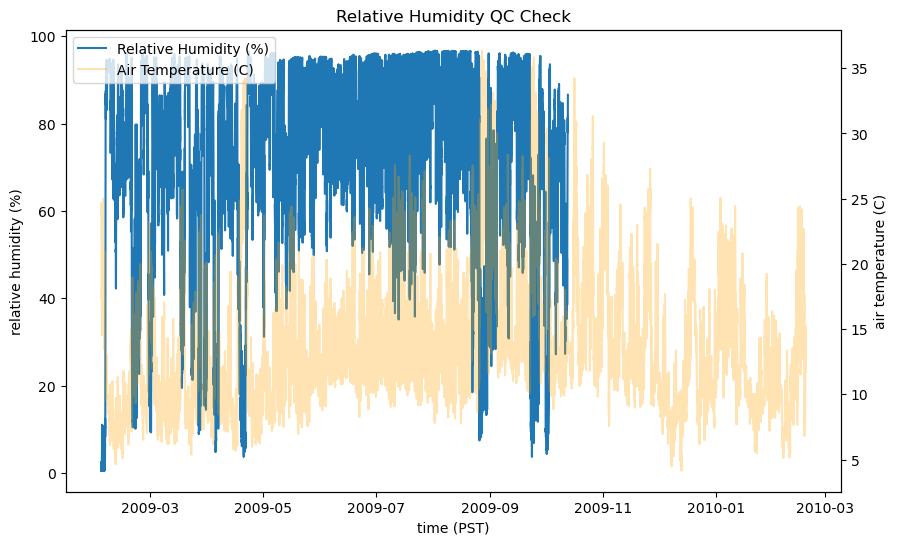

In [269]:
#### Set everything after 10-13 to NaN ####
df.loc[df.index > '2009-10-13', 'relative humidity (%)'] = np.nan

# Check the result
rh_subset = df['2009-02-02 11:45:00	':'2010-02-18 15:15:00']

# Plot Temperature/RH
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rh_subset['relative humidity (%)'],
             label='Relative Humidity (%)')
ax2 = ax.twinx()
sns.lineplot(data=rh_subset['air temperature (C)'],
             label='Air Temperature (C)',
             color='orange',
             alpha=0.3,
             ax=ax2)
ax2.legend_.remove()

plt.title('Relative Humidity QC Check')

# Combine legends
handles1, labels1 = ax.get_legend_handles_labels()  # Handles and labels from ax
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles and labels from ax2
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combine and set location

plt.show()

## Quick Check of Wind Data

__Findings__: We lose wind speed data from January 2007 onward. The sensor recording wind gust/direction seems to have failed late in 2009. There's a shift in the wind direction data mid-2004 where we suddenly start seeing more 0s - this warrants further investigation. 

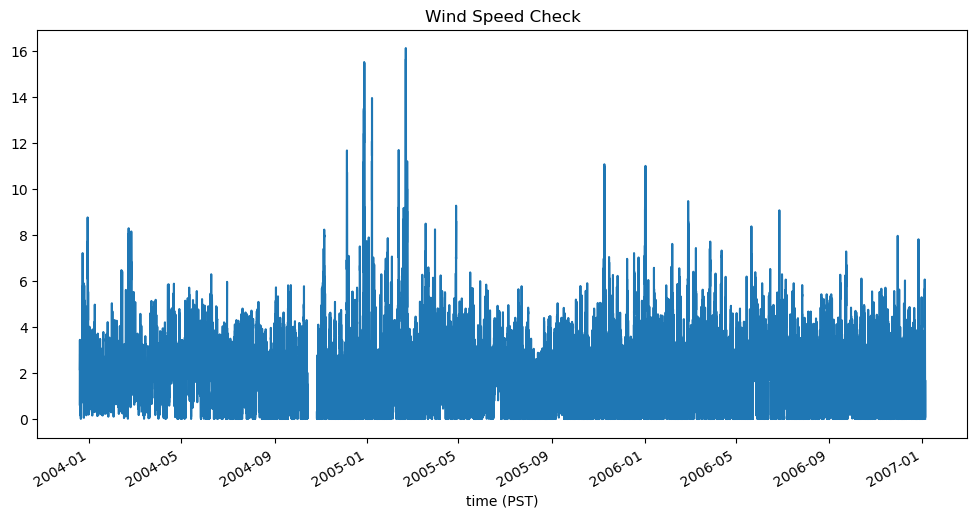

In [270]:
plt.figure(figsize=(12, 6))
df['wind speed (m/s)'].plot()
plt.title('Wind Speed Check')
plt.show()

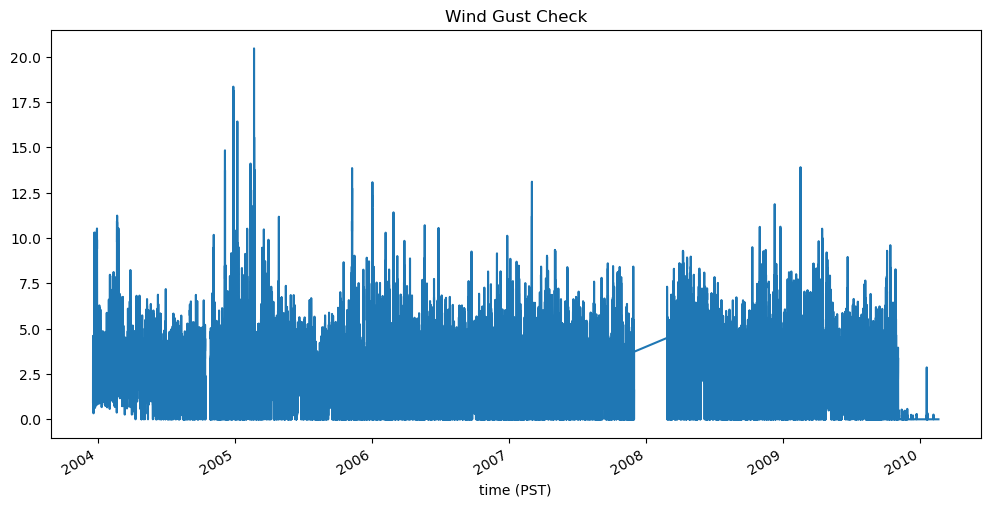

In [271]:
plt.figure(figsize=(12, 6))
df['wind gust (m/s)'].plot()
plt.title('Wind Gust Check')
plt.show()

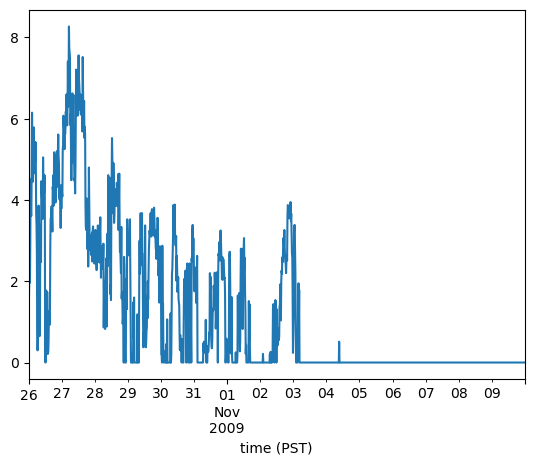

In [272]:
#### The sensor fails ~November 03 2009 ####
wind_subset = df['2009-10-26' : '2009-11-09']
wind_subset['wind gust (m/s)'].plot()
plt.show()

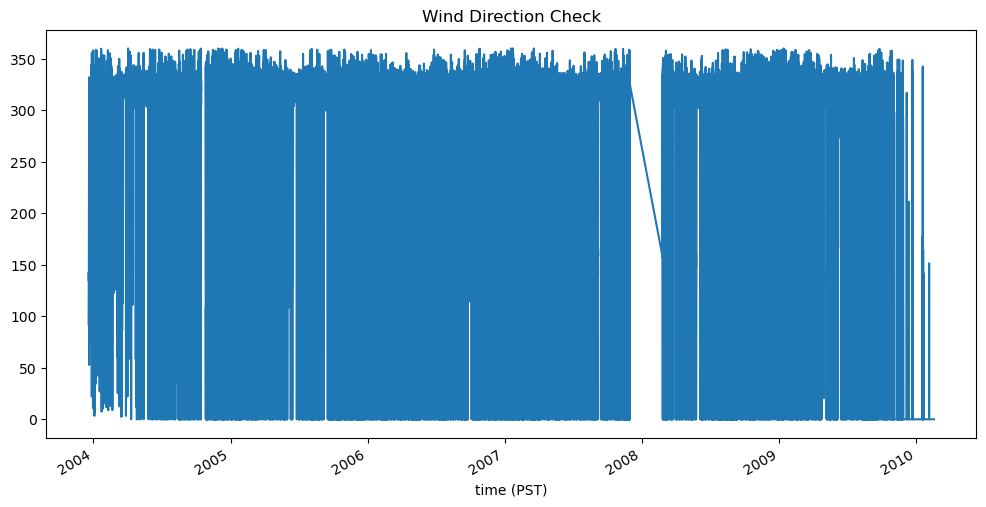

In [273]:
#### Chekc Wind Direction Data ####
plt.figure(figsize=(12, 6))
df['wind direction (deg)'].plot()
plt.title('Wind Direction Check')
plt.show()

In [274]:
#### Remove wind data after november 03, 2009 ####
df.loc[df.index > '2009-11-03', ['wind gust (m/s)', 'wind direction (deg)']] = np.nan

## Rain Check

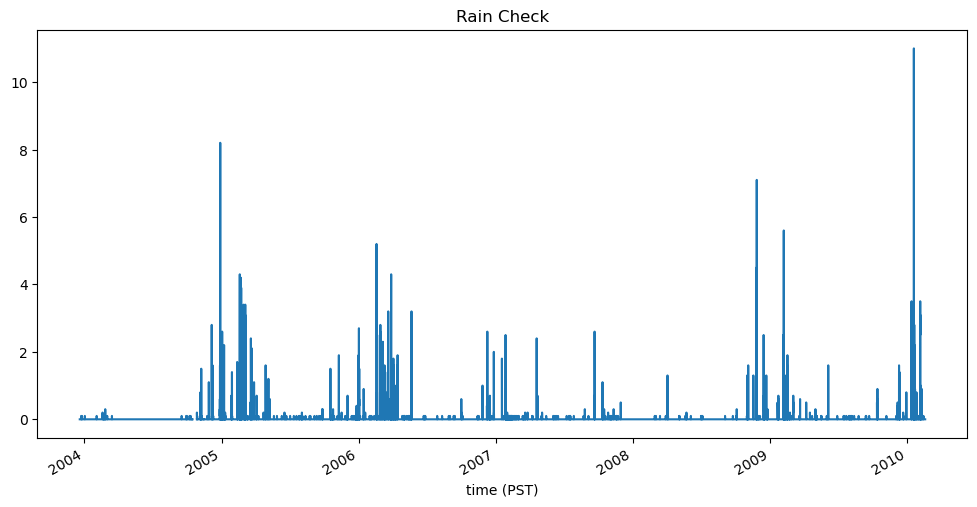

In [275]:
#### Rain Check ####
plt.figure(figsize=(12,6))
df['rain (mm)'].plot()
plt.title('Rain Check')
plt.show()

# Aggregate Data

In [276]:
df_monthly = df.resample('ME').mean()
rain_fog_sums = df[['rain (mm)', 'fog drip']].resample('ME').sum()
df_monthly['rain sum (mm)'] = rain_fog_sums['rain (mm)']
df_monthly['fog drip sum'] = rain_fog_sums['fog drip']
df_monthly.rename(columns={'rain (mm)' : 'rain mean (mm)', 
                           'fog drip' : 'fog drip mean'}, inplace=True)
df_monthly.head(1)

,air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg),wind gust (m/s),rain mean (mm),fog drip mean,rain sum (mm),fog drip sum
time (PST),,,,,,,,,
2003-12-31,10.798176,75.369189,2.571723,217.693277,3.824696,0.002027,0.286662,0.6,84.852


In [277]:
#### Aggregate cumsums from July-July to match WRF output ####
# Rain 
df_monthly['water_year'] = df_monthly.index.year + (df_monthly.index.month >= 7)
df_monthly['rain cumsum (mm)'] = df_monthly.groupby('water_year')['rain sum (mm)'].cumsum()

# Fog
df_monthly['fog cumsum (mm)'] = df_monthly.groupby('water_year')['fog drip sum'].cumsum()

df_monthly.drop('water_year', axis=1, inplace=True)


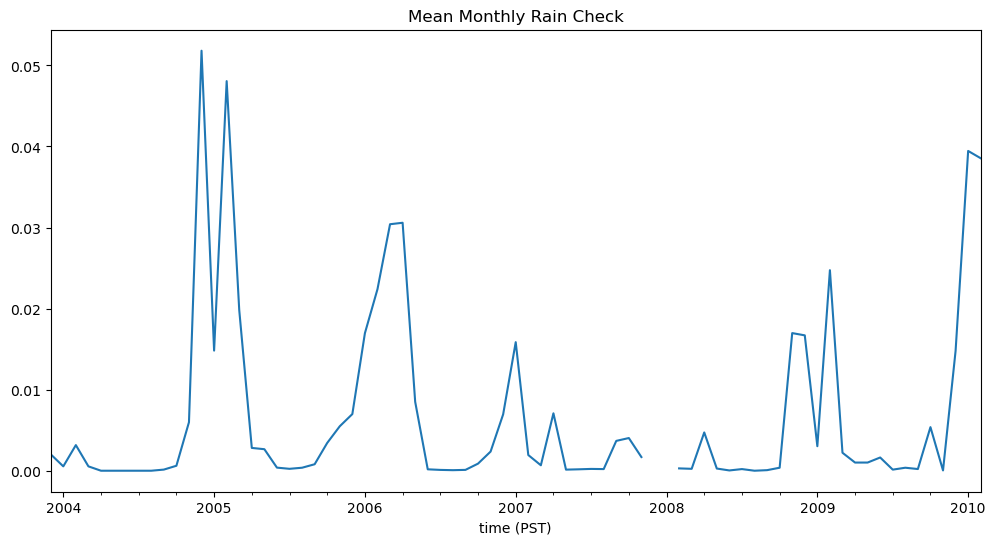

In [278]:
#### Rain Check ####
plt.figure(figsize=(12,6))
df_monthly['rain mean (mm)'].plot()
plt.title('Mean Monthly Rain Check')
plt.show()

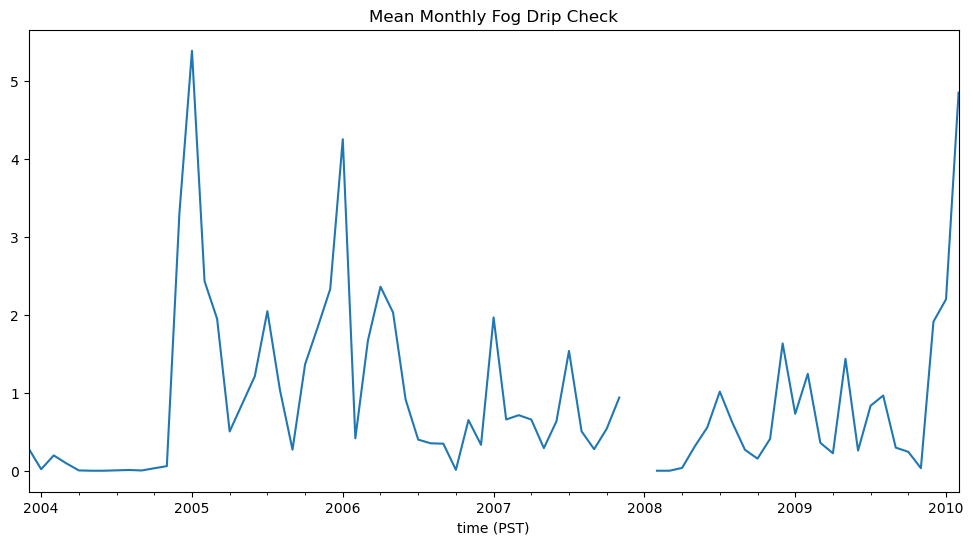

In [279]:
#### Fog Check ####
plt.figure(figsize=(12,6))
df_monthly['fog drip mean'].plot()
plt.title('Mean Monthly Fog Drip Check')
plt.show()

In [286]:
#### Resample fog to hourly to match WRF timescale ####
sum_hourly = df[['fog drip', 'rain (mm)']].resample('h').sum()
max_hourly = df['wind gust (m/s)'].resample('h').max()
mean_hourly = df[['air temperature (C)', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)']].resample('h').mean()

df_hourly = pd.concat([sum_hourly, max_hourly, mean_hourly], axis=1)

In [287]:
df_hourly.head()

,fog drip,rain (mm),wind gust (m/s),air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg)
time (PST),,,,,,,
2003-12-19 16:00:00,0.0,0.0,0.95,15.53,27.54,0.63,92.21
2003-12-19 17:00:00,0.0,0.0,3.96,15.22,27.05,1.40,99.26
2003-12-19 18:00:00,0.0,0.0,3.75,14.68,32.86,2.07,140.33
2003-12-19 19:00:00,0.0,0.0,3.51,12.89,60.68,2.22,122.58
2003-12-19 20:00:00,0.0,0.0,4.60,13.53,49.79,2.62,119.99


# Save out cleaned data

## Save out original data

In [254]:
outdir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/csv/preprocessed'
out_file = 'SAUC_clean.csv'  # NOTE: More prep should be done (e.g. removing data) before this can actually be considered clean
df.to_csv(os.path.join(outdir, out_file))

## Save out monthly aggregated data

In [255]:
out_file = 'SAUC_monthly_clean.csv'  # NOTE: More prep should be done (e.g. removing data) before this can actually be considered clean
df_monthly.to_csv(os.path.join(outdir, out_file))

## Save out hourly data

In [288]:
out_file = 'SAUC_hourly.csv'
df_hourly.to_csv(os.path.join(outdir, out_file))